In [22]:
# extract histogram info from JSON files downloaded from GEE

%matplotlib inline

import glob
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pylab

pylab.rcParams['figure.figsize'] = (12.0, 10.0)

In [1]:
from __future__ import print_function
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
thresholds = []

def read_and_plot_histograms(files):
    for f in files:
        s = file(f).read()
        j = json.loads(s)

        threshold = float(j['threshold_original'])
        
        thresholds.append(threshold)

        if threshold >= 0.4:
            continue

        #print(j)

        y = j['histogram']
        x = j['bucketMeans']

        plt.step(x, y, color='b', alpha=0.01, lw=10)
        # plt.step(x, y)

    # plt.axvline(x=float(th), color='r', alpha=0.2)

    plt.axvline(x=0, color='k')

    plt.xlim(-1, 1)
    plt.ylim(0, 2000)


2684


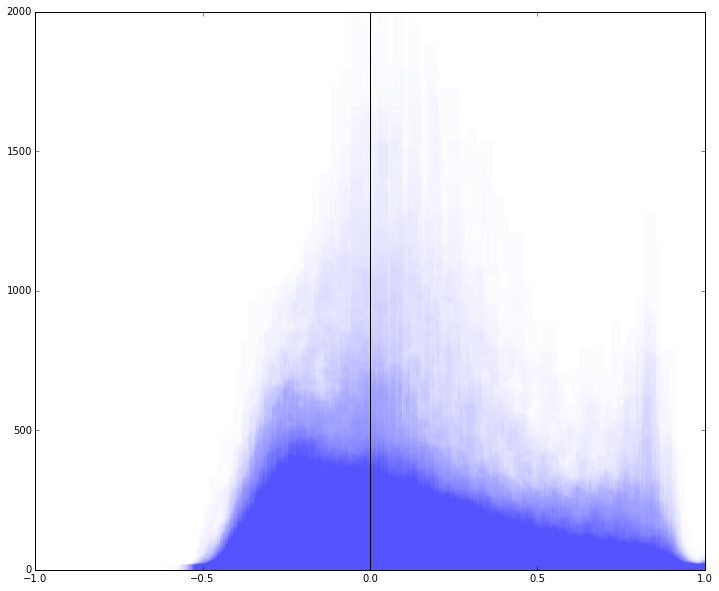

In [6]:
# MNDWI

files = glob.glob('../src/hydro-tools/MNDWI/15/*m.json')
print(len(files))

read_and_plot_histograms(files)

2684


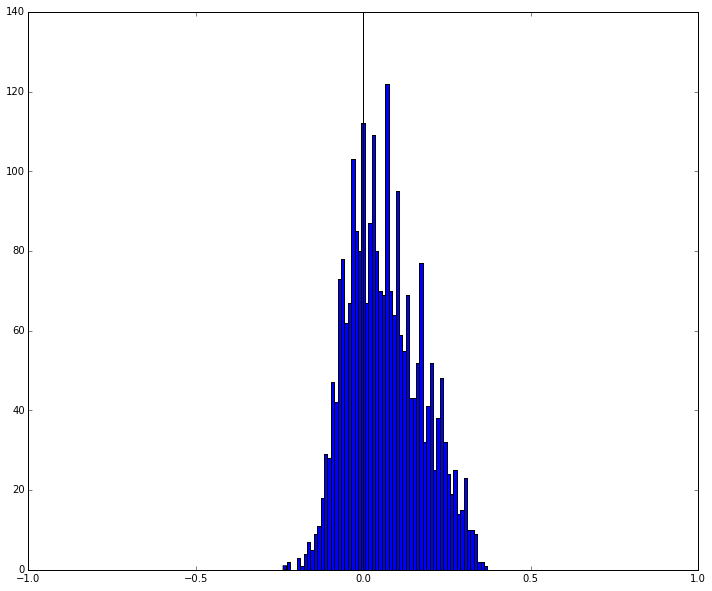

In [9]:
t = np.array(thresholds)
t = t[t<1]
_ = plt.hist(t, 60)
plt.axvline(x=0, color='k')
plt.xlim(-1, 1)

print(len(thresholds))

In [38]:
def get_histogram(f):
        s = file(f).read()
        j = json.loads(s)

        threshold = float(j['threshold'])
        thresholds.append(threshold)

        x = []
        y = []
        
        if threshold != -1:
            y = j['histogram']
            x = j['bucketMeans']
            
        return (threshold, x, y)

def plot_histogram_and_image(dir, hist_path, id, percentile):
    fig = plt.figure(figsize=(15,25))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # zip_path = os.path.join(dir, '{0}_swir1_nir_green_{1}.zip'.format(id, percentile))
    zip_path = os.path.join(dir, '{0}_swir1_nir_green_combined{1}.zip'.format(id, percentile))
    with zipfile.ZipFile(zip_path, 'r') as z:
        # bytes = bytearray(z.read('{0}_swir1_nir_green_{1}.png'.format(id, percentile)))
        bytes = bytearray(z.read('{0}_swir1_nir_green_combined{1}.jpg'.format(id, percentile)))
        image = Image.open(io.BytesIO(bytes))
        ax1.set_title(zip_path)
        ax1.imshow(image)    

    # image_water = []
    # zip_path = os.path.join(dir, '{0}_water_{1}.zip'.format(id, percentile))
    # with zipfile.ZipFile(zip_path, 'r') as z:
        # bytes = bytearray(z.read('{0}_water_{1}.png'.format(id, percentile)))
        # image_water = Image.open(io.BytesIO(bytes))
        #ax1.imshow(image)    

    (threshold, x, y) = get_histogram(hist_path)

    print('id: {0}, percentile: {1}, file: {2}, threshold: {3}'.format(id, percentile, zip_path, threshold))

    ax2.step(x, y)
    ax2.axvline(x=float(threshold), color='r', alpha=0.2)
    ax2.autoscale()
    #ax2.set_ylim(0, 1000)
    ax2.set_xlim(-1, 1)
    ax2.axvline(x=0, color='k')
    

In [32]:
import zipfile
import os
import Image
import io

files = glob.glob('../src/hydro-tools/MNDWI/15/*.json')
files.sort()

def inspect_tile(i):
    hist_path = files[i]
    id = os.path.basename(hist_path)[0:5]
    dir = os.path.dirname(hist_path)
    percentile = dir[-2:]

    plot_histogram_and_image(dir, hist_path, id, percentile)

id: 02505, percentile: 15, file: ../src/hydro-tools/MNDWI/15/02505_swir1_nir_green_combined15.zip, threshold: 0.0


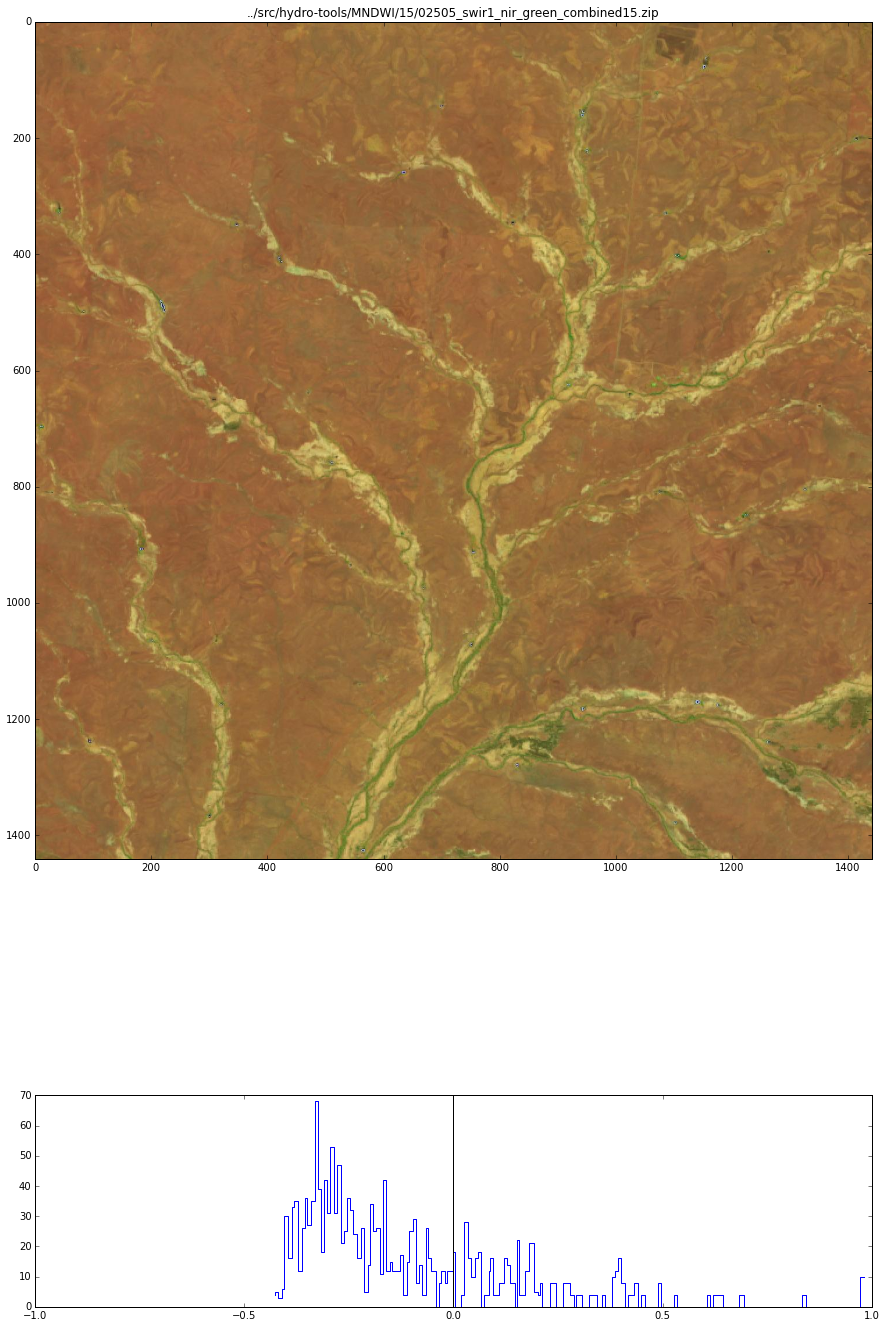

In [39]:
_ = interact(inspect_tile, i=(0,len(files),1))

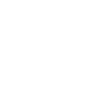

In [162]:
# read grid cells from KML
from pykml import parser
from shapely.geometry.polygon import Polygon
from shapely.geometry.polygon import LinearRing

doc = file("../data/grid.kml").read()
root = parser.fromstring(doc)
placemarks = [c for c in root.Document.Placemark]

def get_feature(placemark):
    data = placemark.ExtendedData.Data
    id = int([d.value for d in placemark.ExtendedData.Data if d.get('name') == 'id'][0])

    scoords = str([d for d in placemark.Polygon.outerBoundaryIs.LinearRing.coordinates][0])[:-1]
    coords = [(float(c[0]), float(c[1])) for c in [p.split(',') for p in scoords.split(' ')]]
    geom = Polygon(LinearRing(coords))
    
    return (id, geom)    

cells = [get_feature(placemark) for placemark in placemarks]

cells[0][1]

In [165]:
# write thresholds to a shapefile
import shapely as sl
from shapely.geometry import mapping
import fiona

index = 'NDWI'
percentile = 15

shp_path = '{0}_{1}p_thresholds.shp'.format(index, percentile)
schema = { 'geometry': 'Polygon', 'properties': {'id': 'int', 'threshold': 'float:15.2'}, }

def get_threshold(index, percentile, id):
    path = '../src/hydro-tools/{0}/{1}/{2:05d}_water_{3}_histogram.json'.format(index, percentile, id, percentile)
    j = json.loads(file(path).read())
    return float(j['threshold'])
print(shp_path)
with fiona.open(shp_path, 'w', 'ESRI Shapefile', schema) as c:
    for cell in cells:
        id = cell[0]
        threshold = get_threshold(index, percentile, id)
        geom = cell[1]
        c.write({'geometry' : mapping(geom), 'properties' : { 'id' : id, 'threshold' : threshold } })


NDWI_15p_thresholds.shp


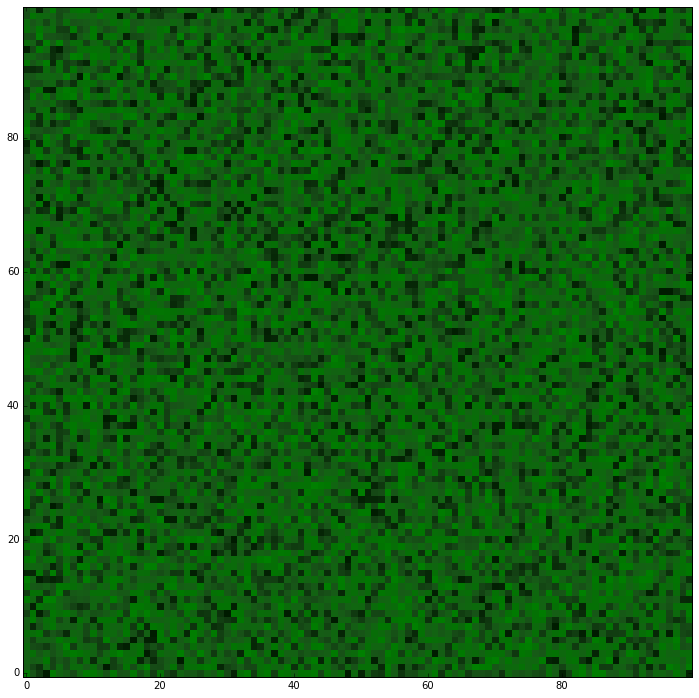

In [127]:
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# create dummy data
zvals = np.ones((100,100))# np.random.rand(100,100)*10-5
zvals2 = np.random.rand(100,100)*10-5

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['green','blue'],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

img2 = plt.imshow(zvals, interpolation='nearest', cmap=cmap1, origin='lower')
img3 = plt.imshow(zvals2, interpolation='nearest', cmap=cmap2, origin='lower')

plt.show()